In [31]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import librosa, librosa.display
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

In [32]:
PATH_METADATA = "musicnet_metadata.csv"

PATH_DATA = "musicnet/data/"
PATH_LABELS = "musicnet/labels/"

PATH_TRAIN_DATA = "musicnet/train_data/"
PATH_TRAIN_LABELS = "musicnet/train_labels/"
PATH_TEST_DATA = "musicnet/test_data/"
PATH_TEST_LABELS = "musicnet/test_labels/"

In [33]:
ORIGINAL_SR = 44100
TARGET_SR = 16000
FMIN = librosa.note_to_hz("A0")
FMIN_MIDI_INDEX = librosa.note_to_midi("A0")
N_NOTES = 88
BINS_PER_NOTE = 1
BINS_PER_OCTAVE = 12 * BINS_PER_NOTE
N_BINS = N_NOTES * BINS_PER_NOTE

WINDOW_LENGTH = 2048
HOP_LENGTH = 512

frac_sr = TARGET_SR / ORIGINAL_SR
sample_indexer = frac_sr / HOP_LENGTH

In [34]:
def load_DNN():
    model = Sequential()
    #model.add(layers.BatchNormalization(input_shape=(N_BINS,)))
    #model.add(layers.Dense(1024, activation=tf.nn.relu))
    model.add(layers.Dense(1024, activation=tf.nn.relu, input_shape=(N_BINS,)))
    model.add(layers.Dropout(.2))
    model.add(layers.Dense(256, activation=tf.nn.relu))
    model.add(layers.Dropout(.2))
    model.add(layers.Dense(N_NOTES, activation=tf.nn.sigmoid))

    model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'])

    checkpoint_path = "DNN_training/{epoch}.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    latest = tf.train.latest_checkpoint(checkpoint_dir)
    latest
    model.load_weights(latest)

    return model

In [35]:
#model = load_DNN()
model = keras.models.load_model('DNN_training/model.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              91136     
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 256)               262400    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 88)                22616     
                                                                 
Total params: 376,152
Trainable params: 376,152
Non-trainable params: 0
_________________________________________________________________


In [38]:
filename = "1759"

x_test = np.load(filename+ "_data.npy" ).transpose()
y_test = np.load(filename+ "_labels.npy" )

print("Data shape: ", x_test.shape)
print("Labels shape: ", y_test.shape)
print("Duration (s): ", x_test.shape[0]*HOP_LENGTH/TARGET_SR)

loss, accuracy = model.evaluate(x_test, y_test)

Data shape:  (6084, 88)
Labels shape:  (6084, 88)
Duration (s):  194.688
191/191 [==============================] - 0s 2ms/step - loss: 0.0591 - accuracy: 0.2945


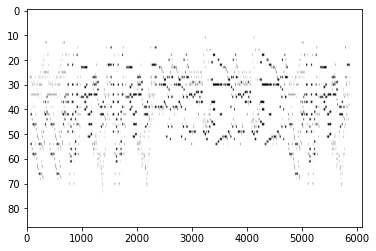

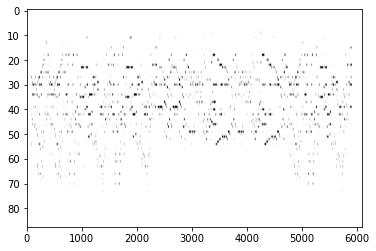

In [39]:
ground_truth = y_test.transpose()
prediction = model.predict(x_test).round().transpose()

plt.figure()
plt.subplot()
plt.imshow(ground_truth,cmap='Greys',aspect='auto')

plt.figure()
plt.subplot()
plt.imshow(prediction,cmap='Greys',aspect='auto')

np.save(filename+"_prediction", prediction)